In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
#print(os.listdir("/Users/snowy/train/train"))

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
cv_targets = pd.read_csv("train.csv")['cv_class']
targets = cv_targets.apply(lambda x : 1 if x == 'real' else 0)
targets

0       1
1       1
2       0
3       1
4       1
       ..
7995    1
7996    1
7997    0
7998    1
7999    0
Name: cv_class, Length: 8000, dtype: int64

In [6]:
images = os.listdir("/Users/snowy/projects/train")

df = pd.DataFrame({
    'filename': images,
    'target': targets
})

In [7]:
images

['63.jpg',
 '6400.jpg',
 '823.jpg',
 '4217.jpg',
 '3578.jpg',
 '2666.jpg',
 '5109.jpg',
 '2100.jpg',
 '4571.jpg',
 '7078.jpg',
 '1409.jpg',
 '6366.jpg',
 '189.jpg',
 '6372.jpg',
 '2114.jpg',
 '4565.jpg',
 '4203.jpg',
 '2672.jpg',
 '6414.jpg',
 '77.jpg',
 '837.jpg',
 '2882.jpg',
 '3544.jpg',
 '5135.jpg',
 '1353.jpg',
 '7722.jpg',
 '7044.jpg',
 '1435.jpg',
 '5653.jpg',
 '3222.jpg',
 '5647.jpg',
 '2128.jpg',
 '3236.jpg',
 '4559.jpg',
 '7050.jpg',
 '1421.jpg',
 '6428.jpg',
 '1347.jpg',
 '7736.jpg',
 '2896.jpg',
 '3550.jpg',
 '5121.jpg',
 '638.jpg',
 '7905.jpg',
 '5874.jpg',
 '5860.jpg',
 '7911.jpg',
 '2869.jpg',
 '7939.jpg',
 '1390.jpg',
 '604.jpg',
 '2699.jpg',
 '2841.jpg',
 '3587.jpg',
 '5848.jpg',
 '5690.jpg',
 '162.jpg',
 '6399.jpg',
 '7087.jpg',
 '176.jpg',
 '7093.jpg',
 '5684.jpg',
 '2855.jpg',
 '3593.jpg',
 '88.jpg',
 '610.jpg',
 '1384.jpg',
 '6164.jpg',
 '4773.jpg',
 '2302.jpg',
 '2464.jpg',
 '4015.jpg',
 '6602.jpg',
 '7508.jpg',
 '1179.jpg',
 '6616.jpg',
 '2470.jpg',
 '4001.jpg',


<AxesSubplot:>

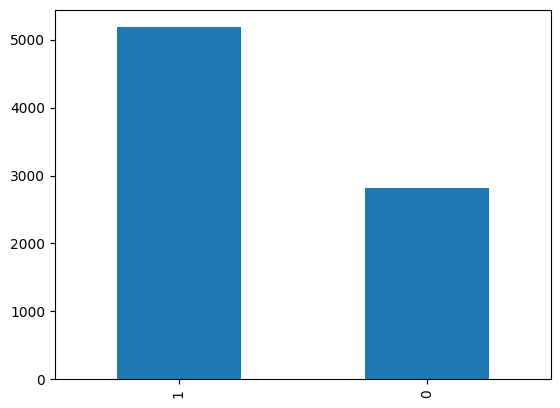

In [8]:
df.head()
df['target'].value_counts().plot.bar()

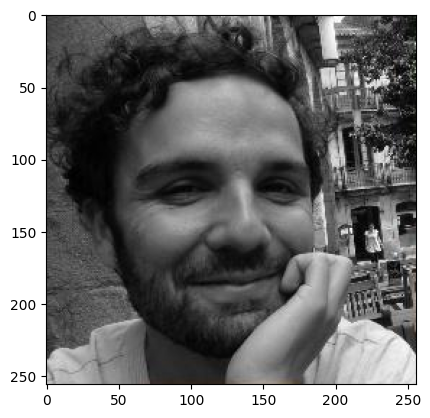

In [9]:
sample = random.choice(images)
image = load_img("/Users/snowy/projects/train/"+sample)
plt.imshow(image)

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [34]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

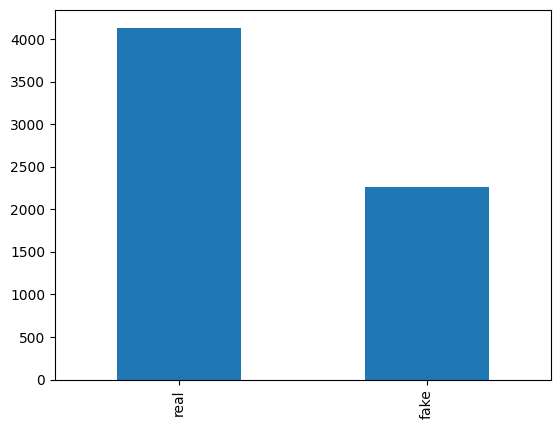

In [35]:
df["target"] = df["target"].replace({0: 'fake', 1: 'real'}) 

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['target'].value_counts().plot.bar()
validate_df['target'].value_counts().plot.bar()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [13]:
train_df

,filename,target
0,70.jpg,real
1,4443.jpg,fake
2,904.jpg,fake
3,5326.jpg,real
4,3573.jpg,real
...,...,...
6395,2781.jpg,real
6396,2347.jpg,fake
6397,6774.jpg,fake
6398,1834.jpg,real


In [39]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/Users/snowy/projects/train/", 
    x_col='filename',
    y_col='target',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 6400 validated image filenames belonging to 2 classes.


In [40]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/Users/snowy/projects/train/", 
    x_col='filename',
    y_col='target',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1600 validated image filenames belonging to 2 classes.


In [38]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/Users/snowy/projects/train/", 
    x_col='filename',
    y_col='target',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [16]:
epochs=3 #if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3


/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_37814/3845751568.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-06-22 12:15:24.676713: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


426/426 [==============================] - ETA: 0s - loss: 1.0255 - accuracy: 0.5544

2023-06-22 12:17:22.130466: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


426/426 [==============================] - 124s 289ms/step - loss: 1.0255 - accuracy: 0.5544 - val_loss: 0.6741 - val_accuracy: 0.6006 - lr: 0.0010
Epoch 2/3
426/426 [==============================] - 114s 269ms/step - loss: 0.7377 - accuracy: 0.5883 - val_loss: 0.6681 - val_accuracy: 0.6314 - lr: 0.0010
Epoch 3/3
426/426 [==============================] - 117s 274ms/step - loss: 0.7044 - accuracy: 0.5887 - val_loss: 0.6561 - val_accuracy: 0.6535 - lr: 0.0010


In [41]:

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/10


2023-06-22 14:21:22.988311: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-22 14:21:24.267005: I tensorflow/core/common_runtime/executor.cc:1210] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [15,65536], In[1]: [200704,128]
	 [[{{node sequential_1/dense_2/Relu}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/dense_2/Relu' defined at (most recent call last):
    File "/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/snowy/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_37814/573777251.py", line 2, in <module>
      history = model.fit(
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/engine/sequential.py", line 404, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/activations.py", line 321, in relu
      return backend.relu(
    File "/opt/homebrew/lib/python3.9/site-packages/keras/src/backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'sequential_1/dense_2/Relu'
Matrix size-incompatible: In[0]: [15,65536], In[1]: [200704,128]
	 [[{{node sequential_1/dense_2/Relu}}]] [Op:__inference_train_function_14640]

In [17]:
model.save_weights("model.h5")

In [18]:
test_filenames = os.listdir("/Users/snowy/projects/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [20]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/Users/snowy/projects/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 2000 validated image filenames.


In [21]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_37814/3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
2023-06-22 12:21:55.988779: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [22]:
test_df['target'] = np.argmax(predict, axis=-1)

In [23]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['target'] = test_df['target'].replace(label_map)

test_df['target'] = test_df['target'].replace({ 'real': 1, 'fake': 0 })

In [30]:
pd.Series(test_df["target"]).to_csv("chancy_cv.csv", index = False)

In [31]:
test_df["target"]

0       1
1       1
2       1
3       1
4       1
       ..
1995    1
1996    1
1997    1
1998    1
1999    1
Name: target, Length: 2000, dtype: int64